In [1]:
import pandas as pd
from scipy.stats import norm
from datetime import date
import math
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import yfinance as yf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.optimize import minimize_scalar  

In [2]:
#help(arch_model)

In [3]:
import time

In [4]:
data = yf.download("^GSPC", start="2005-03-01", end="2016-03-01")
data['pct_change'] = data.Open.pct_change()
data['log_ret'] = np.log(data.Open) - np.log(data.Open.shift(1))
data['log_ret * 100'] = data['log_ret'] * 100

[*********************100%***********************]  1 of 1 completed


In [5]:
am = arch_model(data['log_ret * 100'][1:,], vol='Garch', p=1, o=0, q=1, dist='Normal', mean= "Constant")
print(am)
res = am.fit()
print(res.summary())

Constant Mean(constant: yes, no. of exog: 0, volatility: GARCH(p: 1, q: 1), distribution: Normal distribution)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 5982148836.278509
Iteration:      2,   Func. Count:     15,   Neg. LLF: 583380741.5421997
Iteration:      3,   Func. Count:     22,   Neg. LLF: 5772.801945873122
Iteration:      4,   Func. Count:     29,   Neg. LLF: 3743.1852332439166
Iteration:      5,   Func. Count:     35,   Neg. LLF: 3702.962040911938
Iteration:      6,   Func. Count:     41,   Neg. LLF: 3764.2221224600607
Iteration:      7,   Func. Count:     47,   Neg. LLF: 3688.6296706372505
Iteration:      8,   Func. Count:     52,   Neg. LLF: 3688.614572641492
Iteration:      9,   Func. Count:     57,   Neg. LLF: 3688.614311347419
Iteration:     10,   Func. Count:     62,   Neg. LLF: 3688.6143102947544
Iteration:     11,   Func. Count:     66,   Neg. LLF: 3688.614310295952
Optimization terminated successfully    (Exit mode 0)
            Current function value: 368

In [6]:
np.mean(data['log_ret'][1:,])

0.00017139925950356233

In [7]:
np.var(data['log_ret'][1:,])**0.5

0.012060498049534013

In [8]:
data = data.dropna()

In [9]:
data.to_csv("../Daten/sp500.csv", index=False)

In [10]:
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats

In [11]:
adfuller(data['log_ret'][1:,], regression = "c")

(-13.047087955834403,
 2.1804056506595127e-24,
 17,
 2750,
 {'1%': -3.432730150728559,
  '5%': -2.8625915799748762,
  '10%': -2.567329789619835},
 -16438.536483154858)

t-statistic = -13.05
p-value = 0.000

In [12]:
stats.jarque_bera(data['log_ret'][1:,])

Jarque_beraResult(statistic=13465.572825328949, pvalue=0.0)

In [13]:
stats.kurtosis(data['log_ret'][1:,])

10.77803157055266

In [14]:
stats.skew(data['log_ret'][1:,])

-0.38326135699697206

In [15]:
#data = pd.read_csv("../Daten/sp500.csv")

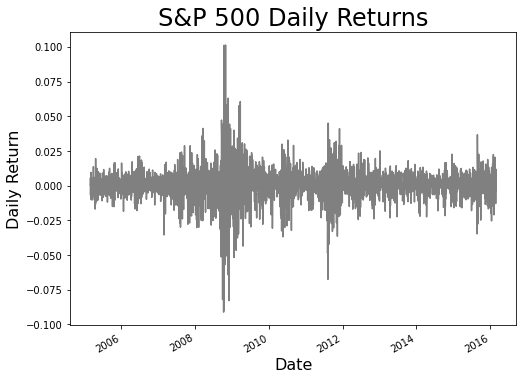

In [16]:
fig = plt.figure(figsize= (8,6))
data["log_ret"].plot(color = "grey")
plt.title("S&P 500 Daily Returns", size = "24")
plt.xlabel('Date', size = "16") 
plt.ylabel('Daily Return', size = "16") 
plt.savefig("../LaTeX Finance/Figures/sp500return_plt",bbox_inches='tight')

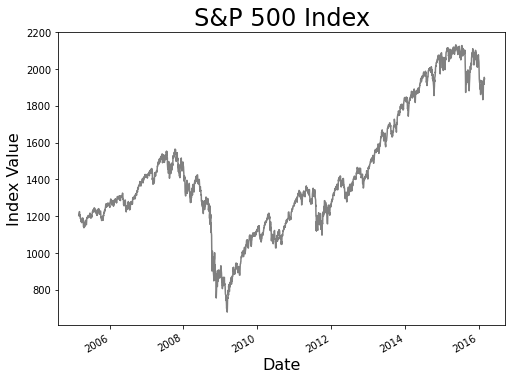

In [17]:
fig = plt.figure(figsize= (8,6))
data["Open"].plot(color = "grey")
plt.title("S&P 500 Index", size = "24")
plt.xlabel('Date', size = "16") 
plt.ylabel('Index Value', size = "16") 
plt.savefig("../LaTeX Finance/Figures/sp500index_plt",bbox_inches='tight')

In [71]:
def sim_option_price_sdf(series, S_t, K, horizon, par, draws, r, model):
    """from Rasmus Petersen Copenhagen"""
    np.random.seed(123)
    if model == "GARCH":
        omega = par[0]/100**2
        alpha = par[1]
        beta = par[2]
        mu = par[3]
        
    S_T = np.zeros(draws)
    temp = np.zeros(draws)  
    
    for i in range(draws):
        ret = np.zeros(horizon)
        theta = np.zeros(horizon)
        sdf = np.zeros(horizon)    
        s = np.var(series) #sigma2[-1]
        s =  omega + alpha*(series[-1]-mu)**2 + beta*s
            
        for j in range(horizon):
            theta[j] = (r-mu)/s - 1/2
            ret[j] = mu +(s)**0.5 * np.random.normal(0,1,1)[0]
           # ret[j] = r -s/2 + np.random.normal(0,s,1)[0]
            sdf[j] = np.exp(theta[j]*ret[j])/np.exp( ((1+theta[j])**2 * s)/2)
            s = omega + alpha*(ret[j]-mu)**2 + beta*s    
            
        rsum = np.sum(ret)
        S_T[i] = S_t * np.exp(rsum)
        prodsdf = np.product(sdf)
        temp[i] = prodsdf * (S_T[i]-K)*(S_T[i]>K)
        
    return np.mean(temp), np.var(temp)**0.5

In [19]:
rahbek_data = pd.read_csv("../Daten/Option_prices_2018_1.csv", sep=';')

In [20]:
rahbek_data

,Quote date,Expiration date,C,K,S,r,T,Days to Mature
0,01.03.2016,18.03.2016,328.30,1650,1978.35,0.0033,0.046600,17
1,01.03.2016,18.03.2016,130.90,1850,1978.35,0.0033,0.046600,17
2,01.03.2016,18.03.2016,112.20,1870,1978.35,0.0033,0.046600,17
3,01.03.2016,18.03.2016,85.50,1900,1978.35,0.0033,0.046600,17
4,01.03.2016,18.03.2016,68.40,1920,1978.35,0.0033,0.046600,17
...,...,...,...,...,...,...,...,...
26432,01.03.2018,20.12.2019,171.55,2850,2677.67,0.0160,1.805479,659
26433,01.03.2018,20.12.2019,148.35,2900,2677.67,0.0160,1.805479,659
26434,01.03.2018,20.12.2019,127.00,2950,2677.67,0.0160,1.805479,659
26435,01.03.2018,18.12.2020,332.60,2700,2677.67,0.0160,2.802740,1023


In [21]:
5**0.5

2.23606797749979

In [22]:
plots_data = rahbek_data.copy()

In [23]:
plots_data_moneyness = plots_data[plots_data["Days to Mature"] < 101]

In [24]:
options_M090095 = plots_data_moneyness[(plots_data["moneyness"] < 0.95) & ((plots_data["moneyness"] >= 0.9))]

KeyError: 'moneyness'

In [ ]:
plots_data["moneyness"] = plots_data["S"]/plots_data["K"]

In [ ]:
hihi = np.where(plots_data["moneyness"].values > 5)

In [ ]:
plots_data.drop(np.where(plots_data["moneyness"].values > 5)[0], inplace = True)

In [ ]:
options_T1 = plots_data[plots_data["Days to Mature"] == 1]
options_T10 = plots_data[plots_data["Days to Mature"] == 10]    
options_T30 = plots_data[plots_data["Days to Mature"] == 30]
options_T45 = plots_data[plots_data["Days to Mature"] == 45]
options_T60 = plots_data[plots_data["Days to Mature"] == 60]
options_T100 = plots_data[plots_data["Days to Mature"] == 100]

In [ ]:
options_M090095 = plots_data_moneyness[(plots_data["moneyness"] < 0.95) & ((plots_data["moneyness"] >= 0.9))]
options_T095100 = plots_data_moneyness[(plots_data["moneyness"] < 1.0) & ((plots_data["moneyness"] >= 0.95))]
options_T100105 = plots_data_moneyness[(plots_data["moneyness"] < 1.05) & ((plots_data["moneyness"] >= 1.0))]
options_T105110 = plots_data_moneyness[(plots_data["moneyness"] < 1.1) & ((plots_data["moneyness"] >= 1.05))]
options_T110115 = plots_data_moneyness[(plots_data["moneyness"] < 1.15) & ((plots_data["moneyness"] >= 1.1))]

In [ ]:
options_M090100 = plots_data_moneyness[(plots_data["moneyness"] < 1.0) & ((plots_data["moneyness"] >= 0.9))]
options_M100110 = plots_data_moneyness[(plots_data["moneyness"] < 1.1) & ((plots_data["moneyness"] >= 1.0))]

In [ ]:
6847 +7578

In [ ]:
options_M090110 = plots_data_moneyness[(plots_data["moneyness"] < 1.1) & ((plots_data["moneyness"] >= 0.9))]
plt.scatter(options_M090110["Days to Mature"].values,options_M090110["C"].values, s = 7, c= options_M090110["moneyness"], cmap='cool')
plt.title(r"Call Market Price (T), $\frac{S}{K} \in (0.9,1.1]$", size = "20")
plt.xlabel(r'Days to Mature', size = "16") 
plt.ylabel('Call Market Price', size = "16")
plt.colorbar()
#plt.legend()
#plt.xlim([0.8, 3]) 
#plt.ylim([-30,375])
plt.savefig("../LaTeX Finance/Figures/disc_maturity_M09_11",bbox_inches='tight')

In [ ]:
plt.scatter(options_M090100["Days to Mature"].values,options_M090100["C"].values, s = 7, c= options_M090100["moneyness"], cmap='cool')
plt.title(r"Call Market Price (T), $\frac{S}{K} \in (0.9,1.0]$", size = "20")
plt.xlabel(r'Days to Mature', size = "16") 
plt.ylabel('Call Market Price', size = "16")
plt.colorbar(ticks = (0.92,0.94,0.96,0.98))
#plt.legend()
#plt.xlim([0.8, 3]) 
#plt.ylim([-30,375])
plt.savefig("../LaTeX Finance/Figures/disc_maturity_M09_10",bbox_inches='tight')

In [ ]:
plt.scatter(options_M100110["Days to Mature"].values,options_M100110["C"].values, s = 7, c= options_M100110["moneyness"], cmap='cool')
plt.title(r"Call Market Price (T), $\frac{S}{K} \in (1.0,1.1]$", size = "20")
plt.xlabel(r'Days to Mature', size = "16") 
plt.ylabel('Call Market Price', size = "16")
plt.colorbar()
#plt.legend()
#plt.xlim([0.8, 3]) 
#plt.ylim([-30,375])
plt.savefig("../LaTeX Finance/Figures/disc_maturity_M10_11",bbox_inches='tight')

In [ ]:
print(len(options_M090095))
print(len(options_T095100))
print(len(options_T100105))
print(len(options_T105110))
print(len(options_T110115))

In [ ]:
#options_M090095.plot.scatter(x="Days to Mature", y = "C")
#plt.xlabel(r'Days to Mature$ ', size = "16") 
#plt.ylabel('Call Market Price', size = "16")

In [ ]:
plt.scatter(options_M090095["Days to Mature"].values,options_M090095["C"].values, s = 7, c= options_M090095["moneyness"], cmap='cool')
plt.title(r"Call Market Price, $\frac{S}{K} \in (0.9,0.95]$", size = "20")
plt.xlabel(r'Days to Mature$ ', size = "16") 
plt.ylabel('Call Market Price', size = "16")
plt.colorbar(ticks = (0.91,0.92,0.93,0.94))
#plt.legend()
#plt.xlim([0.8, 3]) 
#plt.ylim([-30,375])
plt.savefig("../LaTeX Finance/Figures/disc_maturity_M090",bbox_inches='tight')

In [ ]:
plt.scatter(options_T095100["Days to Mature"].values,options_T095100["C"].values, s = 7, c= options_T095100["moneyness"], cmap='cool')
plt.title(r"Call Market Price, $\frac{S}{K} \in (0.95,1.0]$", size = "20")
plt.xlabel(r'Days to Mature$ ', size = "16") 
plt.ylabel('Call Market Price', size = "16") 
plt.colorbar(ticks = (0.96,0.97,0.98,0.99))
#plt.xlim([0.8, 3]) 
#plt.ylim([-100,1800])
plt.savefig("../LaTeX Finance/Figures/disc_maturity_M095",bbox_inches='tight')

In [ ]:
plt.scatter(options_T100105["Days to Mature"].values,options_T100105["C"].values, s = 7, c= options_T100105["moneyness"], cmap='cool')
plt.title(r"Call Market Price, $\frac{S}{K} \in (1.0,1.05]$", size = "20")
plt.xlabel(r'Days to Mature$ ', size = "16") 
plt.ylabel('Call Market Price', size = "16") 
plt.colorbar(ticks = (1.01,1.02,1.03,1.04))
#plt.xlim([0.8, 3]) 
#plt.ylim([-100,1800])
plt.savefig("../LaTeX Finance/Figures/disc_maturity_M100",bbox_inches='tight')

In [ ]:
plt.scatter(options_T105110["Days to Mature"].values,options_T105110["C"].values, s = 7, c= options_T105110["moneyness"], cmap='cool')
plt.title(r"Call Market Price, $\frac{S}{K} \in (1.05,1.1]$", size = "20")
plt.xlabel(r'Days to Mature$ ', size = "16") 
plt.ylabel('Call Market Price', size = "16") 
plt.colorbar(ticks = (1.06,1.07,1.08,1.09))
#plt.xlim([0.8, 3]) 
#plt.ylim([-100,1800])
plt.savefig("../LaTeX Finance/Figures/disc_maturity_M105",bbox_inches='tight')

In [ ]:
plt.scatter(options_T110115["Days to Mature"].values,options_T110115["C"].values, s = 7, c= options_T110115["moneyness"], cmap='cool')
plt.title(r"Call Market Price, $\frac{S}{K} \in (1.1,1.15]$", size = "20")
plt.xlabel(r'Days to Mature$ ', size = "16") 
plt.ylabel('Call Market Price', size = "16") 
plt.colorbar(ticks = (1.11,1.12,1.13,1.14))
#plt.xlim([0.8, 3]) 
#plt.ylim([-100,1800])
plt.savefig("../LaTeX Finance/Figures/disc_maturity_M110",bbox_inches='tight')

In [ ]:
options_T1 = plots_data[plots_data["Days to Mature"] == 1]
options_T10 = plots_data[plots_data["Days to Mature"] == 10]
options_T30 = plots_data[plots_data["Days to Mature"] == 30]
options_T45 = plots_data[plots_data["Days to Mature"] == 45]
options_T60 = plots_data[plots_data["Days to Mature"] == 60]
options_T100 = plots_data[plots_data["Days to Mature"] == 100]

In [ ]:
plt.scatter(options_T1["moneyness"].values,options_T1["C"].values, s = 5, color = "grey")
plt.title(r"Call Market Price $(\frac{S}{K})$, $T$ = 1", size = "20")
plt.xlabel(r'Moneyness $(\frac{S}{K})$ ', size = "16") 
plt.ylabel('Call Market Price', size = "16") 
#plt.xscale('log')
plt.xlim([0.8,3])    
plt.ylim([-100,1800])
plt.savefig("../LaTeX Finance/Figures/disc_moneyness_T1",bbox_inches='tight')

In [ ]:
plt.scatter(options_T10["moneyness"].values,options_T10["C"].values, s = 5, color = "grey")
plt.title(r"Call Market Price $(\frac{S}{K})$, $T$ = 10", size = "20")
plt.xlabel(r'Moneyness $(\frac{S}{K})$ ', size = "16") 
plt.ylabel('Call Market Price', size = "16") 
plt.xlim([0.8, 3]) 
plt.ylim([-100,1800])
#plt.savefig("../LaTeX Finance/Figures/disc_moneyness_T10",bbox_inches='tight')

In [ ]:
plt.scatter(options_T30["moneyness"].values,options_T30["C"].values, s = 5, color = "grey")
plt.title(r"Call Market Price $(\frac{S}{K})$, $T$ = 30", size = "20")
plt.xlabel(r'Moneyness $(\frac{S}{K})$ ', size = "16") 
plt.ylabel('Call Market Price', size = "16") 
plt.xlim([0.8, 3])
plt.ylim([-100,1800])
#plt.savefig("../LaTeX Finance/Figures/disc_moneyness_T30",bbox_inches='tight')

In [ ]:
plt.scatter(options_T45["moneyness"].values,options_T45["C"].values, s = 5, color = "grey")
plt.title(r"Call Market Price $(\frac{S}{K})$, $T$ = 45", size = "20")
plt.xlabel(r'Moneyness $(\frac{S}{K})$ ', size = "16") 
plt.ylabel('Call Market Price', size = "16") 
plt.xlim([0.8, 3])
plt.ylim([-100,1800])
#plt.savefig("../LaTeX Finance/Figures/disc_moneyness_T45",bbox_inches='tight')

In [ ]:
plt.scatter(options_T60["moneyness"].values,options_T60["C"].values, s = 5, color = "grey")
plt.title(r"Call Market Price $(\frac{S}{K})$, $T$ = 60", size = "20")
plt.xlabel(r'Moneyness $(\frac{S}{K})$ ', size = "16") 
plt.ylabel('Call Market Price', size = "16") 
plt.xlim([0.8, 3])
plt.ylim([-100,1800])
#plt.savefig("../LaTeX Finance/Figures/disc_moneyness_T60",bbox_inches='tight')

In [ ]:
plt.scatter(options_T100["moneyness"].values,options_T100["C"].values, s = 5, color = "grey")
plt.title(r"Call Market Price $(\frac{S}{K})$, $T$ = 100", size = "20")
plt.xlabel(r'Moneyness $(\frac{S}{K})$ ', size = "16") 
plt.ylabel('Call Market Price', size = "16") 
plt.xlim([0.8, 3])
plt.ylim([-100,1800])
#plt.savefig("../LaTeX Finance/Figures/disc_moneyness_T100",bbox_inches='tight')

In [ ]:
options_T1["moneyness"]

In [39]:
options_T1 = rahbek_data[rahbek_data["Days to Mature"] == 1]
options_T10 = rahbek_data[rahbek_data["Days to Mature"] == 10]
options_T30 = rahbek_data[rahbek_data["Days to Mature"] == 30]
options_T45 = rahbek_data[rahbek_data["Days to Mature"] == 45]
options_T60 = rahbek_data[rahbek_data["Days to Mature"] == 60]
options_T100 = rahbek_data[rahbek_data["Days to Mature"] == 100]

In [40]:
#plt.plot((options_T1[M],options_T1))

In [43]:
options_T1 = rahbek_data[rahbek_data["Days to Mature"] == 2]
options_T10 = rahbek_data[rahbek_data["Days to Mature"] == 11]
options_T30 = rahbek_data[rahbek_data["Days to Mature"] == 31]
options_T45 = rahbek_data[rahbek_data["Days to Mature"] == 46]
options_T60 = rahbek_data[rahbek_data["Days to Mature"] == 59]
options_T100 = rahbek_data[rahbek_data["Days to Mature"] == 101]

In [45]:
print(len(options_T1))
print(len(options_T10))
print(len(options_T30))
print(len(options_T45))
print(len(options_T60))
print(len(options_T100))

337
197
330
184
236
112


In [46]:
#options_T45.head(60)

In [72]:
frame_list = [options_T1,options_T10,options_T30,options_T45,options_T60,options_T100]

In [73]:


u = 0
for element in frame_list:
    option_sub = element
    GARCH_opt_p = np.zeros(len(option_sub))
    for i in range(len(option_sub)):
        if i % 20 == 0:
            print(i)
        GARCH_opt_p[i] = sim_option_price_sdf(series = data["log_ret"], S_t = option_sub.iloc[i,4], K = option_sub.iloc[i,3], horizon = option_sub.iloc[i,7], par = np.array([0.0198,0.1003,0.8816,0.0001737859]), draws = 500, r = option_sub.iloc[i,5]/251, model = "GARCH" )[0]
    print(GARCH_opt_p)
    if u==0:
        options_T1["GARCH price"] = GARCH_opt_p
    if u==1:
        options_T10["GARCH price"] = GARCH_opt_p
    if u==2:
        options_T30["GARCH price"] = GARCH_opt_p
    if u==3:
        options_T45["GARCH price"] = GARCH_opt_p
    if u==4:
        options_T60["GARCH price"] = GARCH_opt_p
    if u==5:
        options_T100["GARCH price"] = GARCH_opt_p
    u = u+1



0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
[  95.53162124   90.54212576   75.66936959   65.86735481   56.23350164
   51.51817146   38.0705075    33.87458449   29.84519304   22.32582833
   18.96867443   15.91636504   13.22438794   10.88807213    7.02552603
    4.2711326    80.77629635   61.2517324    56.46235543   51.76909283
   47.18137208   42.73117697   38.40440233   34.2319236    30.2168992
   26.34016449   22.73732852   19.39195797   16.34455407   13.64739009
   11.29928954    9.23566458  946.99430452  170.99336707  125.93524812
  115.9223328   100.91928813   90.93649469   76.06736046   66.2693459
   51.92738356   42.83836773   26.34574664   16.27217903   11.18898342
    7.28147565 1071.00647867  144.80264614   70.04571009   25.61026025
   18.74897928   10.83599845  170.6892545   145.65702812  100.62806005
   90.67645155   85.71317001   80.76767812   75.85031371   70.95825081
   51.88824851   38.64112446   34.51023256   30.50951485   26.67555576
   23.10537724   

C:\Users\MZB\AppData\Local\Temp/ipykernel_9672/3412236091.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_T1["GARCH price"] = GARCH_opt_p


20
40
60
80
100
120
140
160
180
[9.99852818e+02 1.90169999e+02 1.55623478e+02 1.07615234e+02
 8.52361148e+01 6.49417451e+01 5.38757862e+01 4.69983784e+01
 4.05676662e+01 3.75584918e+01 3.46723976e+01 3.19038994e+01
 2.92864447e+01 2.67888093e+01 2.02000352e+01 1.47382176e+01
 1.17951641e+01 4.74601740e+01 4.11067813e+01 3.25181901e+01
 2.99184460e+01 2.74363910e+01 2.08659679e+01 1.70679299e+01
 1.42956752e+02 1.33270352e+02 1.19020581e+02 1.09712425e+02
 4.57579987e+01 4.25788585e+01 2.85743573e+01 2.39573814e+01
 1.45137639e+01 1.15378571e+02 8.01629269e+01 7.21545433e+01
 4.38136808e+01 4.07534700e+01 3.78259033e+01 3.49923139e+01
 3.23003717e+01 2.50536744e+01 9.05274028e+01 8.63246433e+01
 8.21870061e+01 7.81369757e+01 7.03620570e+01 5.23683959e+01
 4.90367892e+01 4.27506070e+01 3.69351930e+01 3.42035673e+01
 2.46128513e+01 1.03868151e+02 9.49837071e+01 5.21505818e+01
 4.55501165e+01 3.94585210e+01 3.65828429e+01 3.38272385e+01
 3.12123645e+01 2.87080327e+01 2.63818541e+01 2.41803

C:\Users\MZB\AppData\Local\Temp/ipykernel_9672/3412236091.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_T10["GARCH price"] = GARCH_opt_p


20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
[ 104.57666937   97.23613817   64.52093903   58.79386556   43.92924847
   39.78195298   31.02195094  125.32216651  102.5424771    88.57350678
   58.12088712   52.96122654   50.53834491   48.22319776   45.98333845
   43.84939847   39.84360399   36.24137109   29.85081045  992.43315296
   88.27789935   78.34802711   63.10379038   60.26982962   57.51433199
   54.86519027   52.30360508   49.85231253   43.10245817   33.77167111
  556.8564622   502.63259505  428.76699363  211.30080527  120.64208915
   71.64028855   62.77677236   59.97371858   57.26225993   54.64327245
   45.17036207   27.71736183   99.32339071   95.82710738   82.51687609
   73.19474436   67.25597152   61.62513108   53.84822314   51.45522126
   46.9411814    42.79843787 1171.36180861  206.02510393  196.90647908
  192.37279776   76.14457045   73.13034914   70.13694156   67.21319613
   64.37506349   61.60776669   58.94425694   53.87290819   49.20610103
   37.36297701 11

C:\Users\MZB\AppData\Local\Temp/ipykernel_9672/3412236091.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_T30["GARCH price"] = GARCH_opt_p


20
40
60
80
100
120
140
160
180
[  73.81892545   61.20208481   50.24704603   41.17620592   33.84511048
 1071.71641977  334.5932786   114.97411802   77.1988216    74.43093936
   71.76466471   69.18186213   64.20669317   57.21926944   38.63700628
  199.33609169  190.7391002   110.61276417   79.86969334   74.47434106
   71.90196945   69.38481785   55.56838564   45.93378241   74.43750364
   66.87654586   62.11913953   59.86374932   51.39143002  821.52344409
  149.41025803   81.61371713   70.76907531   68.24449972   65.78665203
   61.03286907   58.77948211   56.56395486   38.558205    310.8588804
   72.93475405   67.96724024   60.97269193   50.56679803   42.10441671
   34.94327466 1270.90335684  288.86147399   89.71451735   84.00712491
   81.27335382   78.61438968   76.03390377   73.50459938   63.97919104
   59.55924453   53.41184949   47.95130063   44.70503908   41.70892917
   36.0432585    31.00859732 1366.01986236  381.8757348   266.95995534
  262.32470443  235.20871275  230.7652515   12

C:\Users\MZB\AppData\Local\Temp/ipykernel_9672/3412236091.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_T45["GARCH price"] = GARCH_opt_p


20
40
60
80
100
120
140
160
180
200
220
[  99.40579303   96.37569602   84.71572796   71.56593897   61.98785353
   49.61806717 1085.60729009  134.59813755  113.9650804   101.4036535
   89.55530035   86.73653151   81.30267424   78.68735411   76.11641189
   73.58393554   55.40474076   51.49582944   42.58646244   83.13957593
   75.18210978   72.63596339   70.12408122   65.29806134   62.95157507
   60.67159389   58.46414862   56.32997213   48.51550444   39.87804444
   38.35568217   35.4107671    27.57634578   25.25019141  584.19869795
   94.07993174   80.07884376   77.47756585   67.53003537   46.83885042
  128.49027122  111.90811216   82.75551658   80.15599566   77.59773681
   70.20084089   67.82895456   58.98291353   49.35721001   44.1390524
  156.62545797  152.89906407  127.86562607  124.44611675  111.45789428
  108.36092137   82.54707331   74.9108602    70.07978649   58.9883121
   53.11009313   41.11481251   69.80300226   48.89627911 1124.89088095
  165.24577038  111.74652187   96.469097

C:\Users\MZB\AppData\Local\Temp/ipykernel_9672/3412236091.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_T60["GARCH price"] = GARCH_opt_p


20
40
60
80
100
[ 951.87432258   90.39426586   78.70219759   58.53413172   42.36511605
   35.55910833   88.67394708   67.17050027   49.56419817  232.96026839
  142.06754694  110.30064666  100.09264235   88.16009466   77.23146992
   61.56779301   58.07736687   42.60501681  123.01509919  101.9379038
   97.09047963   92.32615639   85.44031494   74.9246283    65.13588344
   56.42151036  154.34274846  100.62731736   68.12154684  235.06748763
  103.32012517   91.38533706   70.27853283   52.84855953  143.3320304
   89.43562978   78.4798776    68.34323116  103.35830292  100.89046452
   80.1604359  1470.05110731 1373.58257962 1180.64552425  344.35211264
  238.05831081  105.84145266   93.80606094   82.72170097   72.46005383
   63.15674828   54.7577738    50.13103721   77.74965852  561.98167546
  112.65817623 1336.83690773 1240.21539166  378.38726303  107.73935497
  105.31331865   93.75388609   73.27008074   87.17197567  500.10524315
  236.15987089  121.74675447  109.26016031   99.73022635 1400.0

C:\Users\MZB\AppData\Local\Temp/ipykernel_9672/3412236091.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_T100["GARCH price"] = GARCH_opt_p


In [50]:
#for element in frame_list:
#    print(element)

In [74]:
optionpGARCH = pd.concat(frame_list)

In [75]:
optionpGARCH.to_csv("../Daten/different_options_GARCH_precise_conmean0605_testP.csv", index=False)

In [70]:
optionsold = pd.read_csv("../Daten/diffoptionsGARCH.csv")

In [76]:
optionpGARCH

,Quote date,Expiration date,C,K,S,r,T,Days to Mature,GARCH price
610,16.03.2016,18.03.2016,96.75,1930,2027.22,0.0031,0.005480,2,95.531621
611,16.03.2016,18.03.2016,91.80,1935,2027.22,0.0031,0.005480,2,90.542126
612,16.03.2016,18.03.2016,77.25,1950,2027.22,0.0031,0.005480,2,75.669370
613,16.03.2016,18.03.2016,66.90,1960,2027.22,0.0031,0.005480,2,65.867355
614,16.03.2016,18.03.2016,56.90,1970,2027.22,0.0031,0.005480,2,56.233502
...,...,...,...,...,...,...,...,...,...
25007,06.02.2018,18.05.2018,159.15,2600,2695.14,0.0150,0.276712,101,182.194902
25008,06.02.2018,18.05.2018,140.95,2625,2695.14,0.0150,0.276712,101,166.951726
25009,06.02.2018,18.05.2018,122.70,2650,2695.14,0.0150,0.276712,101,152.632041
25010,06.02.2018,18.05.2018,89.70,2700,2695.14,0.0150,0.276712,101,126.411880


In [54]:
optionpGARCH

,Quote date,Expiration date,C,K,S,r,T,Days to Mature,GARCH price
610,16.03.2016,18.03.2016,96.75,1930,2027.22,0.0031,0.005480,2,97.007674
611,16.03.2016,18.03.2016,91.80,1935,2027.22,0.0031,0.005480,2,92.007080
612,16.03.2016,18.03.2016,77.25,1950,2027.22,0.0031,0.005480,2,77.005298
613,16.03.2016,18.03.2016,66.90,1960,2027.22,0.0031,0.005480,2,67.004110
614,16.03.2016,18.03.2016,56.90,1970,2027.22,0.0031,0.005480,2,57.002923
...,...,...,...,...,...,...,...,...,...
25007,06.02.2018,18.05.2018,159.15,2600,2695.14,0.0150,0.276712,101,101.804307
25008,06.02.2018,18.05.2018,140.95,2625,2695.14,0.0150,0.276712,101,78.218124
25009,06.02.2018,18.05.2018,122.70,2650,2695.14,0.0150,0.276712,101,54.631942
25010,06.02.2018,18.05.2018,89.70,2700,2695.14,0.0150,0.276712,101,7.459578


In [55]:
optionpGARCH

,Quote date,Expiration date,C,K,S,r,T,Days to Mature,GARCH price
610,16.03.2016,18.03.2016,96.75,1930,2027.22,0.0031,0.005480,2,97.007674
611,16.03.2016,18.03.2016,91.80,1935,2027.22,0.0031,0.005480,2,92.007080
612,16.03.2016,18.03.2016,77.25,1950,2027.22,0.0031,0.005480,2,77.005298
613,16.03.2016,18.03.2016,66.90,1960,2027.22,0.0031,0.005480,2,67.004110
614,16.03.2016,18.03.2016,56.90,1970,2027.22,0.0031,0.005480,2,57.002923
...,...,...,...,...,...,...,...,...,...
25007,06.02.2018,18.05.2018,159.15,2600,2695.14,0.0150,0.276712,101,101.804307
25008,06.02.2018,18.05.2018,140.95,2625,2695.14,0.0150,0.276712,101,78.218124
25009,06.02.2018,18.05.2018,122.70,2650,2695.14,0.0150,0.276712,101,54.631942
25010,06.02.2018,18.05.2018,89.70,2700,2695.14,0.0150,0.276712,101,7.459578


In [72]:
mean_squared_error(optionsold["GARCH price"], optionpGARCH["GARCH price"])

865.3104422716341

In [86]:
mean_squared_error(rahbek_data.iloc[optionpGARCH.index.values]["C"], optionpGARCH["GARCH price"])

577.0411667513844

In [87]:
mean_squared_error(rahbek_data.iloc[optionpGARCH.index.values]["C"], optionsold["GARCH price"])

1461.76033226775

In [100]:
mean_squared_error(all_opt_est_precise["C"], all_opt_est_precise["GARCH price"])

577.0411667513844

In [101]:
mean_squared_error(all_opt_est_precise["C"], all_opt_est_precise["BS price"])

389.2102777195516

In [102]:
mean_absolute_error(all_opt_est_precise["C"], all_opt_est_precise["GARCH price"])

18.234995810508853

In [103]:
mean_absolute_error(all_opt_est_precise["C"], all_opt_est_precise["BS price"])

13.603573108748908

In [77]:
rahbek_data.iloc[optionpGARCH.index.values]

,Quote date,Expiration date,C,K,S,r,T,Days to Mature
610,16.03.2016,18.03.2016,96.75,1930,2027.22,0.0031,0.005480,2
611,16.03.2016,18.03.2016,91.80,1935,2027.22,0.0031,0.005480,2
612,16.03.2016,18.03.2016,77.25,1950,2027.22,0.0031,0.005480,2
613,16.03.2016,18.03.2016,66.90,1960,2027.22,0.0031,0.005480,2
614,16.03.2016,18.03.2016,56.90,1970,2027.22,0.0031,0.005480,2
...,...,...,...,...,...,...,...,...
25007,06.02.2018,18.05.2018,159.15,2600,2695.14,0.0150,0.276712,101
25008,06.02.2018,18.05.2018,140.95,2625,2695.14,0.0150,0.276712,101
25009,06.02.2018,18.05.2018,122.70,2650,2695.14,0.0150,0.276712,101
25010,06.02.2018,18.05.2018,89.70,2700,2695.14,0.0150,0.276712,101


In [78]:
all_opt_est_precise = rahbek_data.iloc[optionpGARCH.index.values]
all_opt_est_precise["GARCH price"] = optionpGARCH["GARCH price"]

C:\Users\MZB\AppData\Local\Temp/ipykernel_9672/3211530732.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_opt_est_precise["GARCH price"] = optionpGARCH["GARCH price"]


In [79]:
for_BS = pd.read_csv("../Daten/all_opt_est.csv")

In [81]:
#for_BS

In [59]:
all_opt_est_precise["BS price"] = for_BS["BS price"].values

ValueError: Length of values (1624) does not match length of index (1396)

In [82]:
for_BS

,Quote date,Expiration date,C,K,S,r,T,Days to Mature,GARCH price,BS price
0,17.03.2016,18.03.2016,939.95,1100,2040.59,0.0029,0.002740,1,940.891763,9.405773e+02
1,17.03.2016,18.03.2016,140.10,1900,2040.59,0.0029,0.002740,1,144.456122,1.405680e+02
2,17.03.2016,18.03.2016,125.05,1915,2040.59,0.0029,0.002740,1,117.334811,1.255679e+02
3,17.03.2016,18.03.2016,120.05,1920,2040.59,0.0029,0.002740,1,123.138227,1.205678e+02
4,17.03.2016,18.03.2016,110.05,1930,2040.59,0.0029,0.002740,1,110.121551,1.105677e+02
...,...,...,...,...,...,...,...,...,...,...
1619,10.01.2018,20.04.2018,12.40,2850,2748.23,0.0140,0.273973,100,125.689924,0.000000e+00
1620,07.02.2018,18.05.2018,90.75,2675,2681.66,0.0153,0.273973,100,170.507003,-9.695575e+00
1621,07.02.2018,18.05.2018,75.20,2700,2681.66,0.0153,0.273973,100,165.026432,-7.182087e-14
1622,07.02.2018,18.05.2018,17.50,2850,2681.66,0.0153,0.273973,100,30.784826,0.000000e+00


In [107]:
all_opt_est_precise.to_csv("../Daten/all_opt_est_precise.csv", index=False)

In [84]:
optionpGARCH.index.values

array([  610,   611,   612, ..., 25009, 25010, 25011], dtype=int64)

In [85]:
optionpGARCH

,Quote date,Expiration date,C,K,S,r,T,Days to Mature,GARCH price
610,16.03.2016,18.03.2016,96.75,1930,2027.22,0.0031,0.005480,2,95.531621
611,16.03.2016,18.03.2016,91.80,1935,2027.22,0.0031,0.005480,2,90.542126
612,16.03.2016,18.03.2016,77.25,1950,2027.22,0.0031,0.005480,2,75.669370
613,16.03.2016,18.03.2016,66.90,1960,2027.22,0.0031,0.005480,2,65.867355
614,16.03.2016,18.03.2016,56.90,1970,2027.22,0.0031,0.005480,2,56.233502
...,...,...,...,...,...,...,...,...,...
25007,06.02.2018,18.05.2018,159.15,2600,2695.14,0.0150,0.276712,101,182.194902
25008,06.02.2018,18.05.2018,140.95,2625,2695.14,0.0150,0.276712,101,166.951726
25009,06.02.2018,18.05.2018,122.70,2650,2695.14,0.0150,0.276712,101,152.632041
25010,06.02.2018,18.05.2018,89.70,2700,2695.14,0.0150,0.276712,101,126.411880


In [71]:
optionpGARCH["S"][690]

2040.59

In [62]:
def d1(S, K, sigma, t, r):
    nominator = np.log(S/K) + (r + (sigma**2)/2)*t
    denominator = sigma* t**0.5
    return nominator/denominator
def d2(S, K, sigma, t, r):
    return d1(S, K, sigma, t, r) - sigma*t**0.5
def BS(S, K, sigma, t, r):
    return S * norm.cdf(d1(S, K, sigma, t, r)) - K * math.e**(r*t) * norm.cdf(d2(S, K, sigma, t, r))

In [63]:
BS_opt_p = np.zeros(len(optionpGARCH))
j = 0
for i, row in optionpGARCH.iterrows():
    BS_opt_p[j] = BS(S = optionpGARCH["S"][i], K = optionpGARCH["K"][i], sigma = np.var(data['log_ret']), t = optionpGARCH["Days to Mature"][i]/251, r = optionpGARCH["r"][i])
    j = j + 1

In [86]:
BS_opt_p

array([ 97.1723261 ,  92.1722026 ,  77.17183207, ...,  29.09661099,
       -21.20609446,   0.        ])

In [87]:
optionpGARCH["BS price"] = BS_opt_p

In [88]:
all_opt_est = optionpGARCH

In [89]:
all_opt_est

,Quote date,Expiration date,C,K,S,r,T,Days to Mature,GARCH price,BS price
610,16.03.2016,18.03.2016,96.75,1930,2027.22,0.0031,0.005480,2,95.531621,97.172326
611,16.03.2016,18.03.2016,91.80,1935,2027.22,0.0031,0.005480,2,90.542126,92.172203
612,16.03.2016,18.03.2016,77.25,1950,2027.22,0.0031,0.005480,2,75.669370,77.171832
613,16.03.2016,18.03.2016,66.90,1960,2027.22,0.0031,0.005480,2,65.867355,67.171585
614,16.03.2016,18.03.2016,56.90,1970,2027.22,0.0031,0.005480,2,56.233502,57.171338
...,...,...,...,...,...,...,...,...,...,...
25007,06.02.2018,18.05.2018,159.15,2600,2695.14,0.0150,0.276712,101,182.194902,79.399316
25008,06.02.2018,18.05.2018,140.95,2625,2695.14,0.0150,0.276712,101,166.951726,54.247964
25009,06.02.2018,18.05.2018,122.70,2650,2695.14,0.0150,0.276712,101,152.632041,29.096611
25010,06.02.2018,18.05.2018,89.70,2700,2695.14,0.0150,0.276712,101,126.411880,-21.206094


In [70]:
all_opt_est.to_csv("../Daten/all_opt_est_0605_Q.csv", index=False)

In [ ]:
all_opt_est.head()

In [82]:
C_50 = all_opt_est["C"]
BS_50 = all_opt_est["BS price"]
GARCH_50 = all_opt_est["GARCH price"]

In [83]:
BS_MSE = mean_squared_error(C_50, BS_50)
GARCH_MSE = mean_squared_error(C_50, GARCH_50)

In [84]:
print(f'{BS_MSE:.2f}, {GARCH_MSE:.2f}')

389.21, 1461.76


In [85]:
options_T1 = all_opt_est[all_opt_est["Days to Mature"] == 1]

In [90]:
def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*N(-d1)   

In [99]:
def implied_vol(opt_value, S, K, T, r, type_='call'):
    """from https://www.codearmo.com/python-tutorial/calculating-volatility-smile"""
    def call_obj(sigma):
        return abs(BS_CALL(S, K, T, r, sigma) - opt_value)
    res = minimize_scalar(call_obj, bounds=(0.0000001,10), method='bounded')
    return res.x


In [100]:
all_opt_est["GARCH imp vol"] = np.zeros(len(all_opt_est))
all_opt_est["BS imp vol"] = np.zeros(len(all_opt_est))

In [101]:
all_opt_est

,Quote date,Expiration date,C,K,S,r,T,Days to Mature,GARCH price,BS price,GARCH imp vol,BS imp vol
687,17.03.2016,18.03.2016,939.95,1100,2040.59,0.0029,0.002740,1,940.891763,9.405773e+02,0.0,0.0
688,17.03.2016,18.03.2016,140.10,1900,2040.59,0.0029,0.002740,1,144.456122,1.405680e+02,0.0,0.0
689,17.03.2016,18.03.2016,125.05,1915,2040.59,0.0029,0.002740,1,117.334811,1.255679e+02,0.0,0.0
690,17.03.2016,18.03.2016,120.05,1920,2040.59,0.0029,0.002740,1,123.138227,1.205678e+02,0.0,0.0
691,17.03.2016,18.03.2016,110.05,1930,2040.59,0.0029,0.002740,1,110.121551,1.105677e+02,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
23217,10.01.2018,20.04.2018,12.40,2850,2748.23,0.0140,0.273973,100,125.689924,0.000000e+00,0.0,0.0
25093,07.02.2018,18.05.2018,90.75,2675,2681.66,0.0153,0.273973,100,170.507003,-9.695575e+00,0.0,0.0
25094,07.02.2018,18.05.2018,75.20,2700,2681.66,0.0153,0.273973,100,165.026432,-7.182087e-14,0.0,0.0
25095,07.02.2018,18.05.2018,17.50,2850,2681.66,0.0153,0.273973,100,30.784826,0.000000e+00,0.0,0.0


In [102]:
N = norm.cdf
for i, row in all_opt_est.iterrows():
    all_opt_est["GARCH imp vol"][i] = implied_vol(all_opt_est["GARCH price"][i], all_opt_est["S"][i], all_opt_est["K"][i], all_opt_est["Days to Mature"][i], all_opt_est["r"][i])
    all_opt_est["BS imp vol"][i] = implied_vol(all_opt_est["BS price"][i], all_opt_est["S"][i], all_opt_est["K"][i], all_opt_est["Days to Mature"][i], all_opt_est["r"][i])
    #print(i)

C:\Users\MZB\AppData\Local\Temp/ipykernel_14180/3143874903.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_opt_est["GARCH imp vol"][i] = implied_vol(all_opt_est["GARCH price"][i], all_opt_est["S"][i], all_opt_est["K"][i], all_opt_est["Days to Mature"][i], all_opt_est["r"][i])
C:\Users\MZB\AppData\Local\Temp/ipykernel_14180/3143874903.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_opt_est["BS imp vol"][i] = implied_vol(all_opt_est["BS price"][i], all_opt_est["S"][i], all_opt_est["K"][i], all_opt_est["Days to Mature"][i], all_opt_est["r"][i])


In [104]:
all_opt_est[all_opt_est["Days to Mature"] == 100]

,Quote date,Expiration date,C,K,S,r,T,Days to Mature,GARCH price,BS price,GARCH imp vol,BS imp vol
332,09.03.2016,17.06.2016,878.90,1100,1989.26,0.0030,0.273973,100,896.333735,8.879445e+02,9.999995,9.999995
333,09.03.2016,17.06.2016,207.50,1800,1989.26,0.0030,0.273973,100,220.267636,1.871073e+02,9.999995,9.999995
334,09.03.2016,17.06.2016,78.80,1970,1989.26,0.0030,0.273973,100,40.701807,1.690401e+01,9.999995,9.999995
335,09.03.2016,17.06.2016,75.70,1975,1989.26,0.0030,0.273973,100,37.395882,1.189803e+01,9.999995,9.999995
336,09.03.2016,17.06.2016,60.75,2000,1989.26,0.0030,0.273973,100,99.696300,0.000000e+00,9.999995,9.999995
...,...,...,...,...,...,...,...,...,...,...,...,...
23217,10.01.2018,20.04.2018,12.40,2850,2748.23,0.0140,0.273973,100,125.689924,0.000000e+00,9.999995,9.999995
25093,07.02.2018,18.05.2018,90.75,2675,2681.66,0.0153,0.273973,100,170.507003,-9.695575e+00,9.999995,9.999995
25094,07.02.2018,18.05.2018,75.20,2700,2681.66,0.0153,0.273973,100,165.026432,-7.182087e-14,9.999995,9.999995
25095,07.02.2018,18.05.2018,17.50,2850,2681.66,0.0153,0.273973,100,30.784826,0.000000e+00,9.999995,9.999995


In [105]:
all_opt_est["Moneyness S/K"] = all_opt_est["S"]/all_opt_est["K"]

In [112]:
all_opt_est[all_opt_est["Days to Mature"] == 1]

,Quote date,Expiration date,C,K,S,r,T,Days to Mature,GARCH price,BS price,GARCH imp vol,BS imp vol,Moneyness S/K
687,17.03.2016,18.03.2016,939.950,1100,2040.59,0.0029,0.00274,1,940.891763,940.577291,0.067979,0.067979,1.855082
688,17.03.2016,18.03.2016,140.100,1900,2040.59,0.0029,0.00274,1,144.456122,140.568048,0.009313,0.009313,1.073995
689,17.03.2016,18.03.2016,125.050,1915,2040.59,0.0029,0.00274,1,117.334811,125.567874,0.007855,0.007855,1.065582
690,17.03.2016,18.03.2016,120.050,1920,2040.59,0.0029,0.00274,1,123.138227,120.567817,0.006693,0.006693,1.062807
691,17.03.2016,18.03.2016,110.050,1930,2040.59,0.0029,0.00274,1,110.121551,110.567701,0.004777,0.004777,1.057301
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25639,15.02.2018,16.02.2018,9.400,2730,2731.20,0.0156,0.00274,1,7.633200,1.030321,0.001920,0.001920,1.000440
25640,15.02.2018,16.02.2018,5.750,2735,2731.20,0.0156,0.00274,1,13.436099,0.000000,0.001297,0.001297,0.998611
25641,15.02.2018,16.02.2018,4.150,2740,2731.20,0.0156,0.00274,1,9.193498,0.000000,0.001659,0.001659,0.996788
25642,15.02.2018,16.02.2018,2.425,2745,2731.20,0.0156,0.00274,1,4.474084,0.000000,0.001457,0.001457,0.994973


In [151]:
all_opt_est[all_opt_est["GARCH imp vol"] != all_opt_est["BS imp vol"]]

,Quote date,Expiration date,C,K,S,r,T,Days to Mature,GARCH price,BS price,GARCH imp vol,BS imp vol,Moneyness S/K
695,17.03.2016,18.03.2016,80.10,1960,2040.59,0.0029,0.00274,1,87.450928,80.567354,0.026685,0.005212,1.041117
700,17.03.2016,18.03.2016,50.50,1990,2040.59,0.0029,0.00274,1,58.454031,50.567008,0.021907,0.003401,1.025422
702,17.03.2016,18.03.2016,40.30,2000,2040.59,0.0029,0.00274,1,48.172763,40.566892,0.018157,0.002107,1.020295
708,17.03.2016,18.03.2016,11.30,2030,2040.59,0.0029,0.00274,1,20.721306,10.566546,0.012945,0.000784,1.005217
710,17.03.2016,18.03.2016,4.35,2040,2040.59,0.0029,0.00274,1,12.542338,0.566430,0.010975,0.000378,1.000289
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19556,10.10.2017,20.10.2017,63.20,2490,2550.64,0.0106,0.02740,10,78.997260,59.588224,0.004866,0.004866,1.024353
19559,10.10.2017,20.10.2017,17.75,2540,2550.64,0.0106,0.02740,10,28.896283,9.567104,0.003736,0.003736,1.004189
20454,07.11.2017,17.11.2017,10.05,2590,2590.64,0.0120,0.02740,10,37.989771,-0.598543,0.003625,0.003625,1.000247
20455,07.11.2017,17.11.2017,5.50,2600,2590.64,0.0120,0.02740,10,49.165360,0.000000,0.003265,0.003265,0.996400


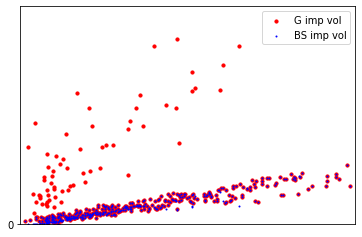

In [149]:



# plot
fig, ax = plt.subplots()
ax.scatter(all_opt_est[all_opt_est["Days to Mature"] == 1]["Moneyness S/K"], all_opt_est[all_opt_est["Days to Mature"] == 1]["GARCH imp vol"], color = "red",  label = "G imp vol" , s = 10)
ax.scatter(all_opt_est[all_opt_est["Days to Mature"] == 1]["Moneyness S/K"], all_opt_est[all_opt_est["Days to Mature"] == 1]["BS imp vol"]   , color = "blue", label = "BS imp vol", s = 1)
ax.set(xlim=(0.99, 1.1), xticks=np.arange(0.9, 1),
       ylim=(0, 0.05), yticks=np.arange(0, 0.1))
plt.legend()
plt.show()

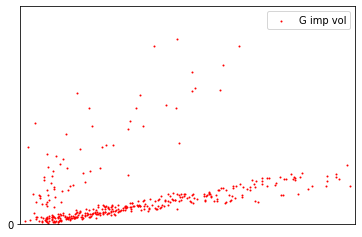

In [144]:
fig, ax = plt.subplots()
ax.scatter(all_opt_est[all_opt_est["Days to Mature"] == 1]["Moneyness S/K"], all_opt_est[all_opt_est["Days to Mature"] == 1]["GARCH imp vol"], color = "red",  label = "G imp vol", s = 1 )
ax.set(xlim=(0.99, 1.1), xticks=np.arange(0.9, 1),
       ylim=(0, 0.05), yticks=np.arange(0, 0.1))
plt.legend()
plt.show()

In [162]:
def sim_option_price_SNG_sdf(series, S_t, K, horizon, par, draws, r):
    """from Rasmus Petersen Copenhagen"""
    omega = par[0]#/100**2
    alpha = par[1]
    beta = par[2] 
    
    v = par[3]
    a = par[4]
    S_T = np.zeros(draws)
    temp = np.zeros(draws)  
    
    for i in range(draws):
        ret = np.zeros(horizon)
        theta = np.zeros(horizon)
        sdf = np.zeros(horizon)    
        s = np.var(series) #sigma2[-1]
        #s =  omega + alpha*series[-1]**2 + beta*s
        s = a
        #print(s) 
        for j in range(horizon):
            b = 1/(1- np.exp( (v*s**0.5 - s/2 - (a*s)**0.5) / a))
            #print(b)
            theta[j] = b - (a/s)**0.5
            eps = np.random.gamma(a, b, 1)[0] - (a*s)**0.5
            #print(eps)
            ret[j] = r + v*s**0.5 - s/2 + eps
            sdf[j] = np.exp(theta[j]*ret[j])/np.exp( (1+theta[j])**2 * s/2)
            s = omega + alpha*eps**2 + beta*s    
            #print(sdf[j], ret[j], theta[j])
        rsum = np.sum(ret)
        S_T[i] = S_t * np.exp(rsum)
        prodsdf = np.product(sdf)
        temp[i] = prodsdf * (S_T[i]-K)*(S_T[i]>K)
        
    return np.mean(temp)

In [163]:
#GARCH_SNG_opt_p = np.zeros(len(option_sub))
i = 0
GARCH_SNG_opt_p = sim_option_price_SNG_sdf(series = data["log_ret"], S_t = option_sub.iloc[i,4], K = option_sub.iloc[i,3], horizon = option_sub.iloc[i,7], par = np.array([0.0198,0.1503,0.6816, 0.9, 4]), draws = 10000, r = 0.003/251)

print(GARCH_SNG_opt_p)

C:\Users\MZB\AppData\Local\Temp/ipykernel_14956/794701728.py:27: RuntimeWarning: overflow encountered in exp
  sdf[j] = np.exp(theta[j]*ret[j])/np.exp( (1+theta[j])**2 * s/2)


511506394.6046866


In [79]:

theta = b - (a/s)**0.5
eps = np.random.gamma(a, b, 1)[0] - (a*s)**0.5
ret = r + v*s**0.5 - s/2 + eps
sdf = np.exp(theta*ret)/np.exp( (1+theta)**2 * s/2)
b = (1- np.exp( alpha**(-1) * v*s**0.5 - s/2 - (a*s)**0.5))**(-1)

In [80]:
v = 0.03
s = 2
alpha = 0.1
a = 5
r = 0.00001

In [81]:
eps

0.36545088466380893

4.22

In [ ]:
def rt(phi0, phi1, psi, epsm1, eps):
    return phi0 + phi1*rt + psi*epsm1 + eps

def epst(a, b, h):
    return (a*h)**0.5 + np.random.gamma(a, b, 1)[0]

def ht(omega, alpha, theta, beta, z, htm1):
    return omega + alpha * z**2 * (z>0) + theta * z**2 * (z<=0) + beta * htm1

4.3

In [109]:
def rt(rcons, v, h, eps):
    return rcons + v*h**0.5 - h/2 + eps
def epst(a, bt, h):
    return (a*h)**0.5 - np.random.gamma(a, b, 1)[0]
def ht(omega, alpha, beta, eps, theta):
    return omega + alpha*(eps - theta* h**0.5)**2 + beta * h
def bt():
    return ( np.exp( a**(-1) * (v*h**0.5 - h/2 + (a * h)**0.5)) - 1)**(-1)
def thetat():
    return bt - (at/ht)**0.5

-2.4490167113760606

3.5

In [ ]:
def rt(rcons, v, h, eps):
    return rcons + v*h**0.5 - h/2 + eps
def epst(a, bt, h):
    return np.random.gamma(a, bt, 1)[0] - (a*h)**0.5
def ht(omega, alpha, epsm1, beta, hm1):
    return omega + alpha*epsm1**2 + beta*hm1
def bt(alpha, v, h, a):
    return (1- np.exp( alpha**(-1) * v*h**0.5  h/2 - (a*h)**0.5))**(-1)
def thetat(bt, at, ht):
    return bt - (at/ht)**0.5

In [173]:
def htq(a,h):
    return a**2 * (1- np.exp( (0.05 * h**0.5 - 0.5 * h - (a*h)**0.5)/a  ))

In [183]:
htq(180,4)

4780.234195571815

In [285]:
def sim_option_price_GAMMAGARCH_sdf(series, S_t, K, horizon, par, draws, r):
    """inspired from Rasmus Petersen Copenhagen"""
    omega = par[0]#/100**2
    alpha = par[1]
    beta = par[2] 
    v = par[3]
    a = par[4]
    S_T = np.zeros(draws)
    temp = np.zeros(draws)  
    
    for i in range(draws):
        ret = np.zeros(horizon)
        theta = np.zeros(horizon)
        sdf = np.zeros(horizon)    
        s = np.var(series) #sigma2[-1]
        #s =  omega + alpha*series[-1]**2 + beta*s
        s = 1.4
        #print(s) 
        for j in range(horizon):
            b = 1/(1- np.exp( (v*s**0.5 - s/2 - (a*s)**0.5) / a))
            #print(b)
            theta[j] = b - (a/s)**0.5
            eps = np.random.gamma(a, b, 1)[0] - r - v*s**0.5 + s/2 + (a*s)**0.5
            #print(eps)
            ret[j] = r + v*s**0.5 - s/2 - (a*s)**0.5 + eps
            sdf[j] = np.exp(theta[j]*ret[j])/np.exp( (1+theta[j])**2 * s/2)
            s = omega + alpha*(eps - (a*s)**0.5)**2 + beta*s 
            #s = a**2 / b
            print(s)
            #print(sdf[j], ret[j], theta[j])
        rsum = np.sum(ret)
        S_T[i] = S_t * np.exp(rsum)
        prodsdf = np.product(sdf)
        temp[i] = prodsdf * (S_T[i]-K)*(S_T[i]>K)
        
    return np.mean(temp)

In [286]:
i = 0
GARCH_GAMMAGARCH_opt_p = sim_option_price_GAMMAGARCH_sdf(series = data["log_ret"], S_t = option_sub.iloc[i,4], K = option_sub.iloc[i,3], horizon = option_sub.iloc[i,7], par = np.array([0.000298,0.1503,0.6816, 0.04, 4]), draws = 10, r = 0.003/251)

print(GARCH_GAMMAGARCH_opt_p)

13.823800072281585
27.775460867705455
71.672827558183
302.15265727406745
3724.144356205117
523722.0998020266
10304543272.137098
3.9898429517285796e+18
5.981506676902298e+35
1.3443742113779408e+70
6.791087640969362e+138
1.7329165908758046e+276
inf
nan
nan
nan
nan
5.051839720368818
10.478012036325122
53.80563822515993
166.32022321358943
1219.150752849266
56831.92727850437
121355304.59321654
553363303804712.56
1.150587621760388e+28
4.9743734216209496e+54
9.297704894851639e+107
3.2482579104139357e+214
inf
nan
nan
nan
nan
7.931312561058687
24.458847800618383
48.233479722172234
140.4156380315956
898.9961106639577
31339.662308632647
36910938.48145349
51191536915615.77
9.846804524881974e+25
3.6432554426226387e+50
4.987446315239954e+99
9.346638745835772e+197
inf
nan
nan
nan
nan
6.539737903848048
13.455634357311125
21.092406837393334
44.48240538390655
151.06616933552397
1045.889963112098
42152.828332713834
66788011.72227791
167605295820362.3
1.0555394216077101e+27
4.186469240659011e+52
6.5855916

C:\Users\MZB\AppData\Local\Temp/ipykernel_14956/2429893613.py:26: RuntimeWarning: overflow encountered in exp
  sdf[j] = np.exp(theta[j]*ret[j])/np.exp( (1+theta[j])**2 * s/2)
C:\Users\MZB\AppData\Local\Temp/ipykernel_14956/2429893613.py:27: RuntimeWarning: overflow encountered in double_scalars
  s = omega + alpha*(eps - (a*s)**0.5)**2 + beta*s
C:\Users\MZB\AppData\Local\Temp/ipykernel_14956/2429893613.py:20: RuntimeWarning: invalid value encountered in double_scalars
  b = 1/(1- np.exp( (v*s**0.5 - s/2 - (a*s)**0.5) / a))
C:\Users\MZB\AppData\Local\Temp/ipykernel_14956/2429893613.py:25: RuntimeWarning: invalid value encountered in double_scalars
  ret[j] = r + v*s**0.5 - s/2 - (a*s)**0.5 + eps


In [268]:
def Y(r,v,a,h,Xt):
    """equation 3.12 siu et al"""
    return r + v*h**0.5 - 0.5* h - (a*h)**0.5 + Xt
def h(omega,alpha,beta,a,ht,Xt):
    """equation 3.13 siu et al"""
    return omega + alpha*(Xt - (a*ht)**0.5)**2 + beta*ht
def htalt(a,v,h):
    """equation 3.14 siu et al"""
    return a**2 * (1- np.exp((v*h**0.5 - 0.5 * h - (a*h)**0.5)/a))
def X(a,b):
    """returns gamma / Xt in siu et al"""
    return np.random.gamma(a, b, 1)[0] 
def b(v,h,a):
    """equation 3.11 in siu et al"""
    return 1/((1- np.exp((v*h**0.5 - 0.5 * h - (a*h)**0.5)/a)))

In [283]:

omega = 0.01
alpha = 0.1
beta = 0.6
v = 0.03
r = 0.001
ht = 1.4
a = 11
print ("{:<8} {:<8} {:<8} {:<8}".format('bt','Xt','ht', "Yt"))

myb = []
myX = []
myh = []
myY = []

for i in range(50):
    bt = b(v,ht,a)
    Xt = X(a, bt)
    ht = h(omega,alpha,beta,a,ht,Xt)
    #ht = htalt(a,v,ht)
    Yt = Y(r,v,a,ht,Xt)
    print ("{:<6.6f} {:<6.6f} {:<6.6f} {:<6.6f}".format( bt, Xt, ht, Yt))
    myb.append(bt), myX.append(Xt), myh.append(ht), myY.append(Yt) 
    
"""plt.figure()
plt.subplot(111)
plt.plot(myb)
plt.plot(myX)
plt.plot(myht)
plt.plot(myY)"""

bt       Xt       ht       Yt      
2.931811 28.978608 63.621918 -29.046571
1.005144 14.333467 52.875120 -36.001877
1.010403 11.669901 47.227924 -34.529593
1.015223 18.023650 30.621138 -15.472907
1.049963 8.962481 27.200863 -21.778160
1.065114 14.156096 17.317468 -8.178685
1.151101 10.979963 11.196808 -5.615023
1.284013 6.552087 8.794587 -7.590913
1.382025 16.794567 10.129373 1.270646
1.322423 10.651721 6.088546 -0.501292
1.569279 18.733217 14.792223 -1.302469
1.193004 15.377140 9.572393 0.423361
1.345501 16.827323 10.064571 1.369317
1.324991 12.391837 6.398411 0.880088
1.541128 17.627356 12.382976 -0.128585
1.248496 16.162530 9.457151 1.327768
1.350578 16.640301 9.832754 1.418981
1.334423 13.445884 6.837385 1.434196
1.504945 10.730036 4.535801 1.463473
1.756328 17.954401 14.592533 -1.895829
1.196932 9.835148 9.568911 -5.115040
1.345653 18.499552 12.541137 0.590905
1.244234 9.297190 8.134016 -4.142336
1.417796 21.719997 19.923420 -2.910779
1.119242 6.929046 18.165499 -16.160628
1.13967

'plt.figure()\nplt.subplot(111)\nplt.plot(myb)\nplt.plot(myX)\nplt.plot(myht)\nplt.plot(myY)'

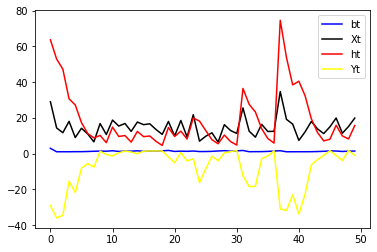

In [284]:
plt.figure()
plt.subplot(111)
plt.plot(myb, color = "blue", label = "bt")
plt.plot(myX, color = "black", label = "Xt")
plt.plot(myh, color = "red", label = "ht")
plt.plot(myY, color = "yellow", label = "Yt")
plt.legend()